# Can we predict the presence of heart disease in patients based on their trestbps and thalach
### -Project proposal

### Yucong Pei 75320754

Heart disease, or cardiovascular disease, is known as the leading cause of death across the globe, accounting for a significant portion of death rates. It includes a variety of conditions that may cause detrimental effects on the heart and blood vessels.

In this project, I aim to use the dataset originating from UCI Heart Disease to build a predictive model that can identify the presence of heart disease in patients based on their health predictors. By observing the data, I believe that resting blood pressure (trestbps) and maximum achieved heart rate (thalach) can be two predictors that classify the disease. So my predictive question is: "Can we predict the presence of heart disease in patients based on their trestbps and thalach"?

The specific dataset I will apply for my paper is the processed Switzerland database, which we can access: https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.switzerland.data


In [110]:
#load library packages
library(tidyverse)
library(repr)
library(tidymodels)
library(repr)
library(RColorBrewer)
options(repr.matrix.max.rows = 6)

In [111]:
#load switzerland data into R and set names for each column
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data"
heart_data <- read_csv(url, col_names = c("age", "sex", "cp", "trestbps", "chol", "fbs", "restecg", 
                                         "thalach", "exang", "oldpeak", "slope", "ca", "thal", "num"))

#wrangling the data, changing all the "?"s to NA
heart_data <- heart_data|>
    filter(ca == "?")|>
    mutate(ca = NA)|>
    bind_rows(heart_data|> filter(ca!="?"))

#converting the columns into the correct data type
heart_data <- heart_data |>
  mutate(sex = as.factor(sex),
  cp = as.factor(cp),
  ca = as.numeric(ca),
  thal = as.factor(thal) ,
  fbs = as.factor(fbs),
  restecg = as.factor(restecg),
  exang = as.factor(exang),     
  slope = as.factor(slope),) |>

#for better understanding, num=0 represents absense of heart disease,
#num≠0 represents the presence of heart disease, I will use conditional mutate 
#to create a new "diagnose" column
mutate(diagnose = case_when(num == 1 ~ "presence",
num == 2 ~ "presence",
num == 3 ~ "presence",
num == 4 ~ "presence",                          
num == 0 ~ "absence"))
heart_data

Rows: 303 Columns: 14
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): ca, thal
dbl (12): age, sex, cp, trestbps, chol, fbs, restecg, thalach, exang, oldpea...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diagnose
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<chr>
52,1,3,138,223,0,0,169,0,0.0,1,NA,3.0,0,absence
43,1,4,132,247,1,2,143,1,0.1,2,NA,7.0,1,presence
58,1,2,125,220,0,0,144,0,0.4,2,NA,7.0,0,absence
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2,7.0,2,presence
57,1,4,130,131,0,0,115,1,1.2,2,1,7.0,3,presence
57,0,2,130,236,0,2,174,0,0.0,2,1,3.0,1,presence


age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,num,diagnose
<dbl>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<fct>,<dbl>,<chr>
58,1,2,125,220,0,0,144,0,0.4,2,NA,7.0,0,absence
38,1,3,138,175,0,0,173,0,0.0,1,NA,3.0,0,absence
63,1,1,145,233,1,2,150,0,2.3,3,0,6.0,0,absence
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮
68,1,4,144,193,1,0,141,0,3.4,2,2,7.0,2,presence
57,1,4,130,131,0,0,115,1,1.2,2,1,7.0,3,presence
57,0,2,130,236,0,2,174,0,0.0,2,1,3.0,1,presence


diagnose,count,percentage
<chr>,<int>,<dbl>
absence,123,54.18502
presence,104,45.81498


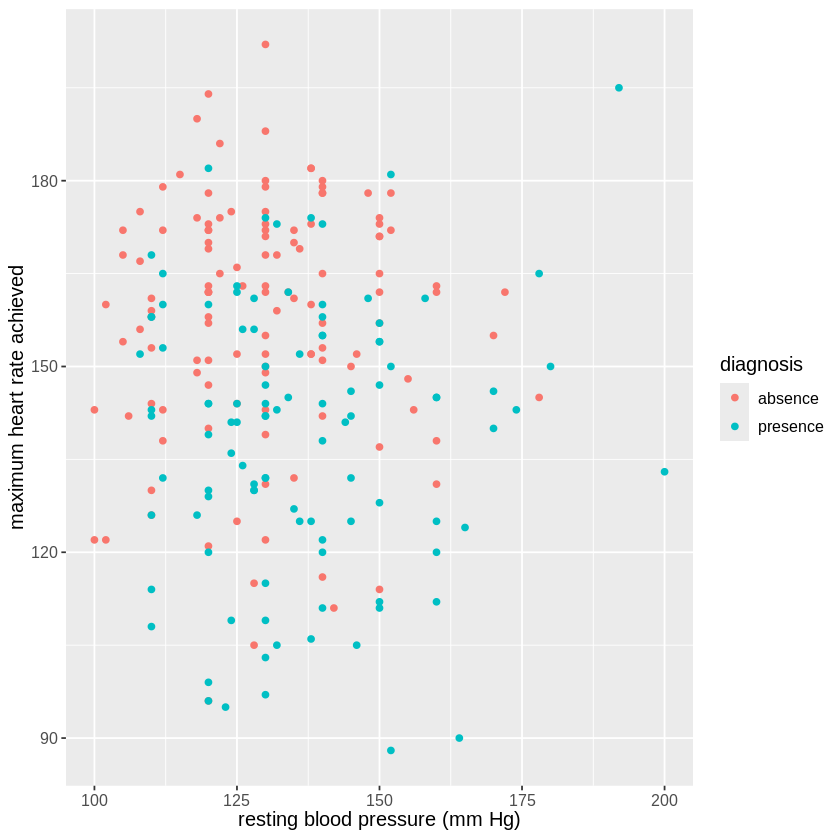

In [119]:
#split the dataset into training and testing set
heart_split <- initial_split(heart_data, prop = 0.75, strata = diagnose)
heart_training <- training(heart_split)
heart_testing <- testing(heart_split)

heart_training

#primarily exploring using the training data
num_obs <- nrow(heart_training)
heart_training |>
  group_by(diagnose) |>
  summarize(
  count = n(),
  percentage = n() / num_obs * 100)
#we have roughly 54% patients diagnosed with heart disease
#now we visualize the training data by creating a scatter plot

heart_plot <- heart_training |>
select(trestbps, thalach, diagnose) |>
#we use trestbps and thalach to predict whether a patient is diagnosed or not
ggplot(aes(x = trestbps, y = thalach, colour = diagnose)) +
geom_point() +
labs(x = "resting blood pressure (mm Hg)", y = "maximum heart rate achieved",
     colour = "diagnosis") +
theme(text = element_text(size = 12))
heart_plot

### Methods: 
* variables:
  The columns of this dataset are a list of predictors and their explanations are given by the UCI website:
  1. age - the age of a patient
  2. sex - sex
  3. cp - chest pain type
  4. trestbps - resting blood pressure(mmHg)
  5. choi - serum cholestoral(mg/dl)
  6. fbs - fasting blood sugar > 120 mg/dl
  7. restecg - resting electrocardiographic results
  8. thalach - maximum heart rate achieved
  9. exang - exercise included angina
   10. oldpeak - induced depression
   11. slope - the slope of the peak exercise ST segment
   12. ca - number of major vessels
   13. thal 
   14. num - here it is replaced by diagnose - diagnosed or notum)

*  From the start, by looking at the data, I found trestbps and thalach may be two driving factors for diagnosing heart disease. So I selected these two columns, along with the diagnosis column, and created a scatter plot. I used the color function to distinguish whether each point represents diagnosed/not.

* visualizing the results:
  
  For this project, I will use the classification methods to predict the presence or absence of heart disease based on these two predictors. Specifically, I will use the K-nearest neighbors algorithm. To predict the presence of heart disease in a new observation (here, to classify it as either present or absent), this algorithm allows us to identify the type of new observation based on the Euclidean distance between surrounding points, and to make predictions based on the majority type of these neighbors. After all, I will also evaluate the accuracy, and precision, of the classifier by approaches such as cross-validation.

### Expected outcomes and significance:

* Expectations:

  From the plot above, I discovered that the "present" points are mostly clustered in the lower left corner of the image. So I expect to find out that, heart disease diagnosis usually occurs when low resting blood pressure and low maximum heart rate.
* Impacts:
  
  The development of this classifier can promote early detection based on the health data of patients who are at risk but may not yet have symptoms. This allows doctors to intervene early with preventive measures, and lower the risk of severe outcomes such as heart attacks.
* Future questions:

  1. What else combinations of the other predictors yields the most accurate classification of heart disease?
  2. How can I develop the accuracy of the classifier?
  3. Does this classifier apply to other regions' heart-disease diagnoses?